<div>
    <font face="Times New Roman" style="text-align: center;">
        <h1>Beyond Reviews</h1>
        <h2>Validating online consumer reviews using unsupervised machine learning methods.</h2>
        <p><strong>Date:</strong> June 15, 2024</p>
        <p><strong>Student:</strong> Maurits Christiaan Graaf</p>
        <p><strong>Studentnumber:</strong> 660509</p>
        <p><strong>Supervisor:</strong> Dr. D.J. (David) Kusterer</p>
        <p><strong>Second Reader:</strong> Dr. M. (Maciej) Szymanowski</p>
        <p><strong>Department:</strong> Marketing</p>
        <p><strong>University:</strong> Rotterdam School of Management</p>
    </font>
</div>

# Importing Packages
This codeblock imports the necessary packages.

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score, jaccard_score
from matplotlib_venn import venn3
from scipy.stats import f_oneway
import gensim
from gensim import corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Maurits\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Maurits\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Datasets

Import the datasets created and prepared in the Fake reviews notebooks

In [2]:
# Define the dataset paths using os
fraud_eagle_path = os.path.join('Output_Data', 'FraudEagle_Output.csv')
speagle_path = os.path.join('Output_Data', 'SpEagle_Output.csv')
asm_path = os.path.join('Output_Data', 'ASM_Output.csv')

# Read the dataframes
fraud_eagle_df = pd.read_csv(fraud_eagle_path)
speagle_df = pd.read_csv(speagle_path)
asm_df = pd.read_csv(asm_path)

# Get and print the shapes of all three DataFrames
fraud_eagle_shape = fraud_eagle_df.shape
speagle_shape = speagle_df.shape
asm_shape = asm_df.shape

print(f"FraudEagle DataFrame shape: {fraud_eagle_shape}")
print(f"SpEagle DataFrame shape: {speagle_shape}")
print(f"ASM DataFrame shape: {asm_shape}")

C:\Users\Maurits\AppData\Local\Temp\ipykernel_14264\4039037471.py:7: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  fraud_eagle_df = pd.read_csv(fraud_eagle_path)
C:\Users\Maurits\AppData\Local\Temp\ipykernel_14264\4039037471.py:8: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  speagle_df = pd.read_csv(speagle_path)
C:\Users\Maurits\AppData\Local\Temp\ipykernel_14264\4039037471.py:9: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  asm_df = pd.read_csv(asm_path)


FraudEagle DataFrame shape: (149880, 50)
SpEagle DataFrame shape: (149880, 63)
ASM DataFrame shape: (149880, 66)


# Computing metrics

### Extracting relevant columns

In [3]:
# Selecting relevant columns per df
# FraudEagle
metrics_cols_fraud_eagle = fraud_eagle_df[['Review_ID', 'Spam_Probability']]

# SpEagle
metrics_cols_speagle = speagle_df[['Review_ID', 'Review_Spam_Probability']]

# ASM
metrics_cols_asm = asm_df[['Review_ID', 'Review_Spamicity']]

In [4]:
# Binarize the spamicity scores based on the threshold of 0.5
metrics_cols_fraud_eagle['Spam'] = (metrics_cols_fraud_eagle['Spam_Probability'] > 0.5).astype(int)
metrics_cols_speagle['Spam'] = (metrics_cols_speagle['Review_Spam_Probability'] > 0.5).astype(int)
metrics_cols_asm['Spam'] = (metrics_cols_asm['Review_Spamicity'] > 0.5).astype(int)

C:\Users\Maurits\AppData\Local\Temp\ipykernel_14264\1712236795.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_cols_fraud_eagle['Spam'] = (metrics_cols_fraud_eagle['Spam_Probability'] > 0.5).astype(int)
C:\Users\Maurits\AppData\Local\Temp\ipykernel_14264\1712236795.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_cols_speagle['Spam'] = (metrics_cols_speagle['Review_Spam_Probability'] > 0.5).astype(int)
C:\Users\Maurits\AppData\Local\Temp\ipykernel_14264\1712236795.py:4: SettingWithCop

In [5]:
# Combine the binarized columns
combined_df = metrics_cols_fraud_eagle[['Review_ID', 'Spam']].rename(columns={'Spam': 'Spam_FraudEagle'})
combined_df = pd.merge(combined_df, metrics_cols_speagle[['Review_ID', 'Spam']], on='Review_ID', how='left').rename(columns={'Spam': 'Spam_SpEagle'})
combined_df = pd.merge(combined_df, metrics_cols_asm[['Review_ID', 'Spam']], on='Review_ID', how='left').rename(columns={'Spam': 'Spam_ASM'})

In [6]:
# Calculate count of True and False spam for each DataFrame
spam_counts = {}
spam_percentages = {}

for df_name in ['Spam_FraudEagle', 'Spam_SpEagle', 'Spam_ASM']:
    counts = combined_df[df_name].value_counts()
    percentages = combined_df[df_name].value_counts(normalize=True) * 100
    
    spam_counts[df_name] = counts
    spam_percentages[df_name] = percentages

# Print the counts and percentages
for df_name, counts in spam_counts.items():
    print(f"Counts for {df_name}:")
    print(counts)
    print()

Counts for Spam_FraudEagle:
Spam_FraudEagle
0    136010
1     13870
Name: count, dtype: int64

Counts for Spam_SpEagle:
Spam_SpEagle
0    117379
1     32501
Name: count, dtype: int64

Counts for Spam_ASM:
Spam_ASM
0    149777
1       103
Name: count, dtype: int64



### Plot the distributions of spam scores

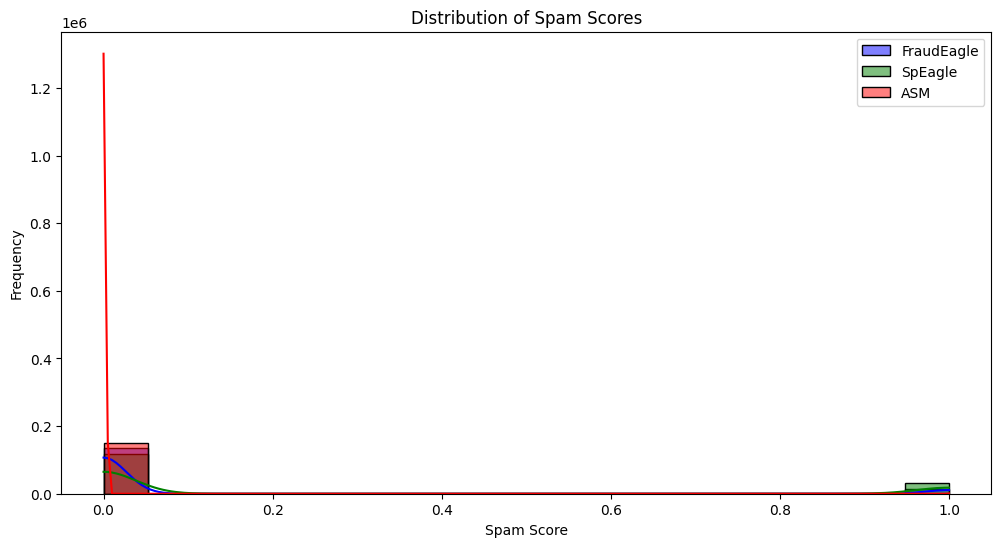

In [7]:
# Plot the distributions of spam scores
plt.figure(figsize=(12, 6))
sns.histplot(combined_df['Spam_FraudEagle'], kde=True, color='blue', label='FraudEagle')
sns.histplot(combined_df['Spam_SpEagle'], kde=True, color='green', label='SpEagle')
sns.histplot(combined_df['Spam_ASM'], kde=True, color='red', label='ASM')
plt.legend()
plt.title('Distribution of Spam Scores')
plt.xlabel('Spam Score')
plt.ylabel('Frequency')
plt.show()

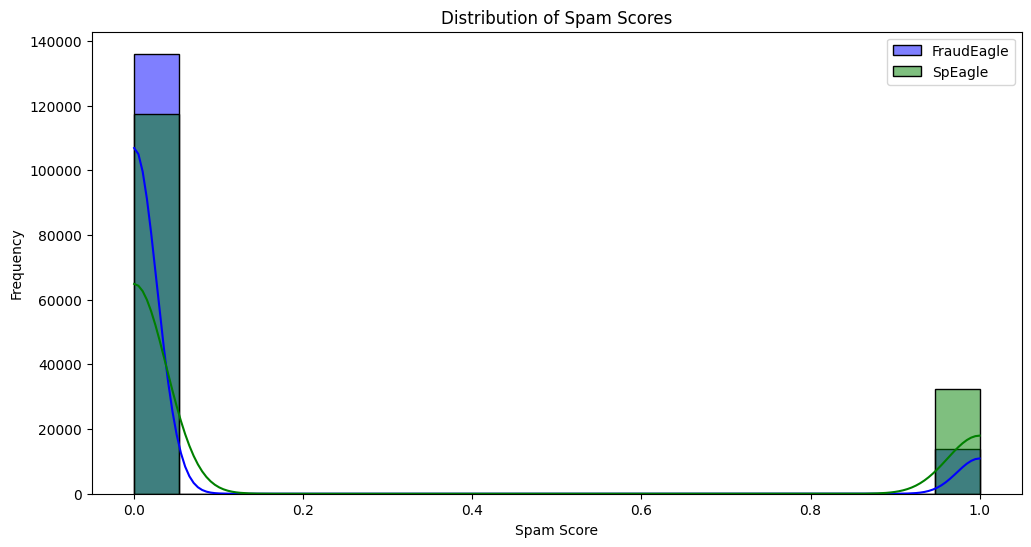

In [8]:
# Plot the distributions of spam scores
plt.figure(figsize=(12, 6))
sns.histplot(combined_df['Spam_FraudEagle'], kde=True, color='blue', label='FraudEagle')
sns.histplot(combined_df['Spam_SpEagle'], kde=True, color='green', label='SpEagle')
plt.legend()
plt.title('Distribution of Spam Scores')
plt.xlabel('Spam Score')
plt.ylabel('Frequency')
plt.show()

#### Other distributional differences

In [9]:
# Define feature columns for correlation analysis
feature_cols = [
    'Review_Rating', 
    'Product_Average_Rating', 
    'Rating_Difference', 'Extreme_Rating',
    'Singular_Review', 
    'First_Person_Pronouns_Ratio', 'Exclamation_Sentence_Ratio',
    'Sentiment_Scores', 'Cosine_Similarity'
]

# Merge the combined spam DataFrame with feature columns from the original DataFrames
full_df = pd.merge(combined_df, fraud_eagle_df[['Review_ID'] + feature_cols], on='Review_ID', how='left')

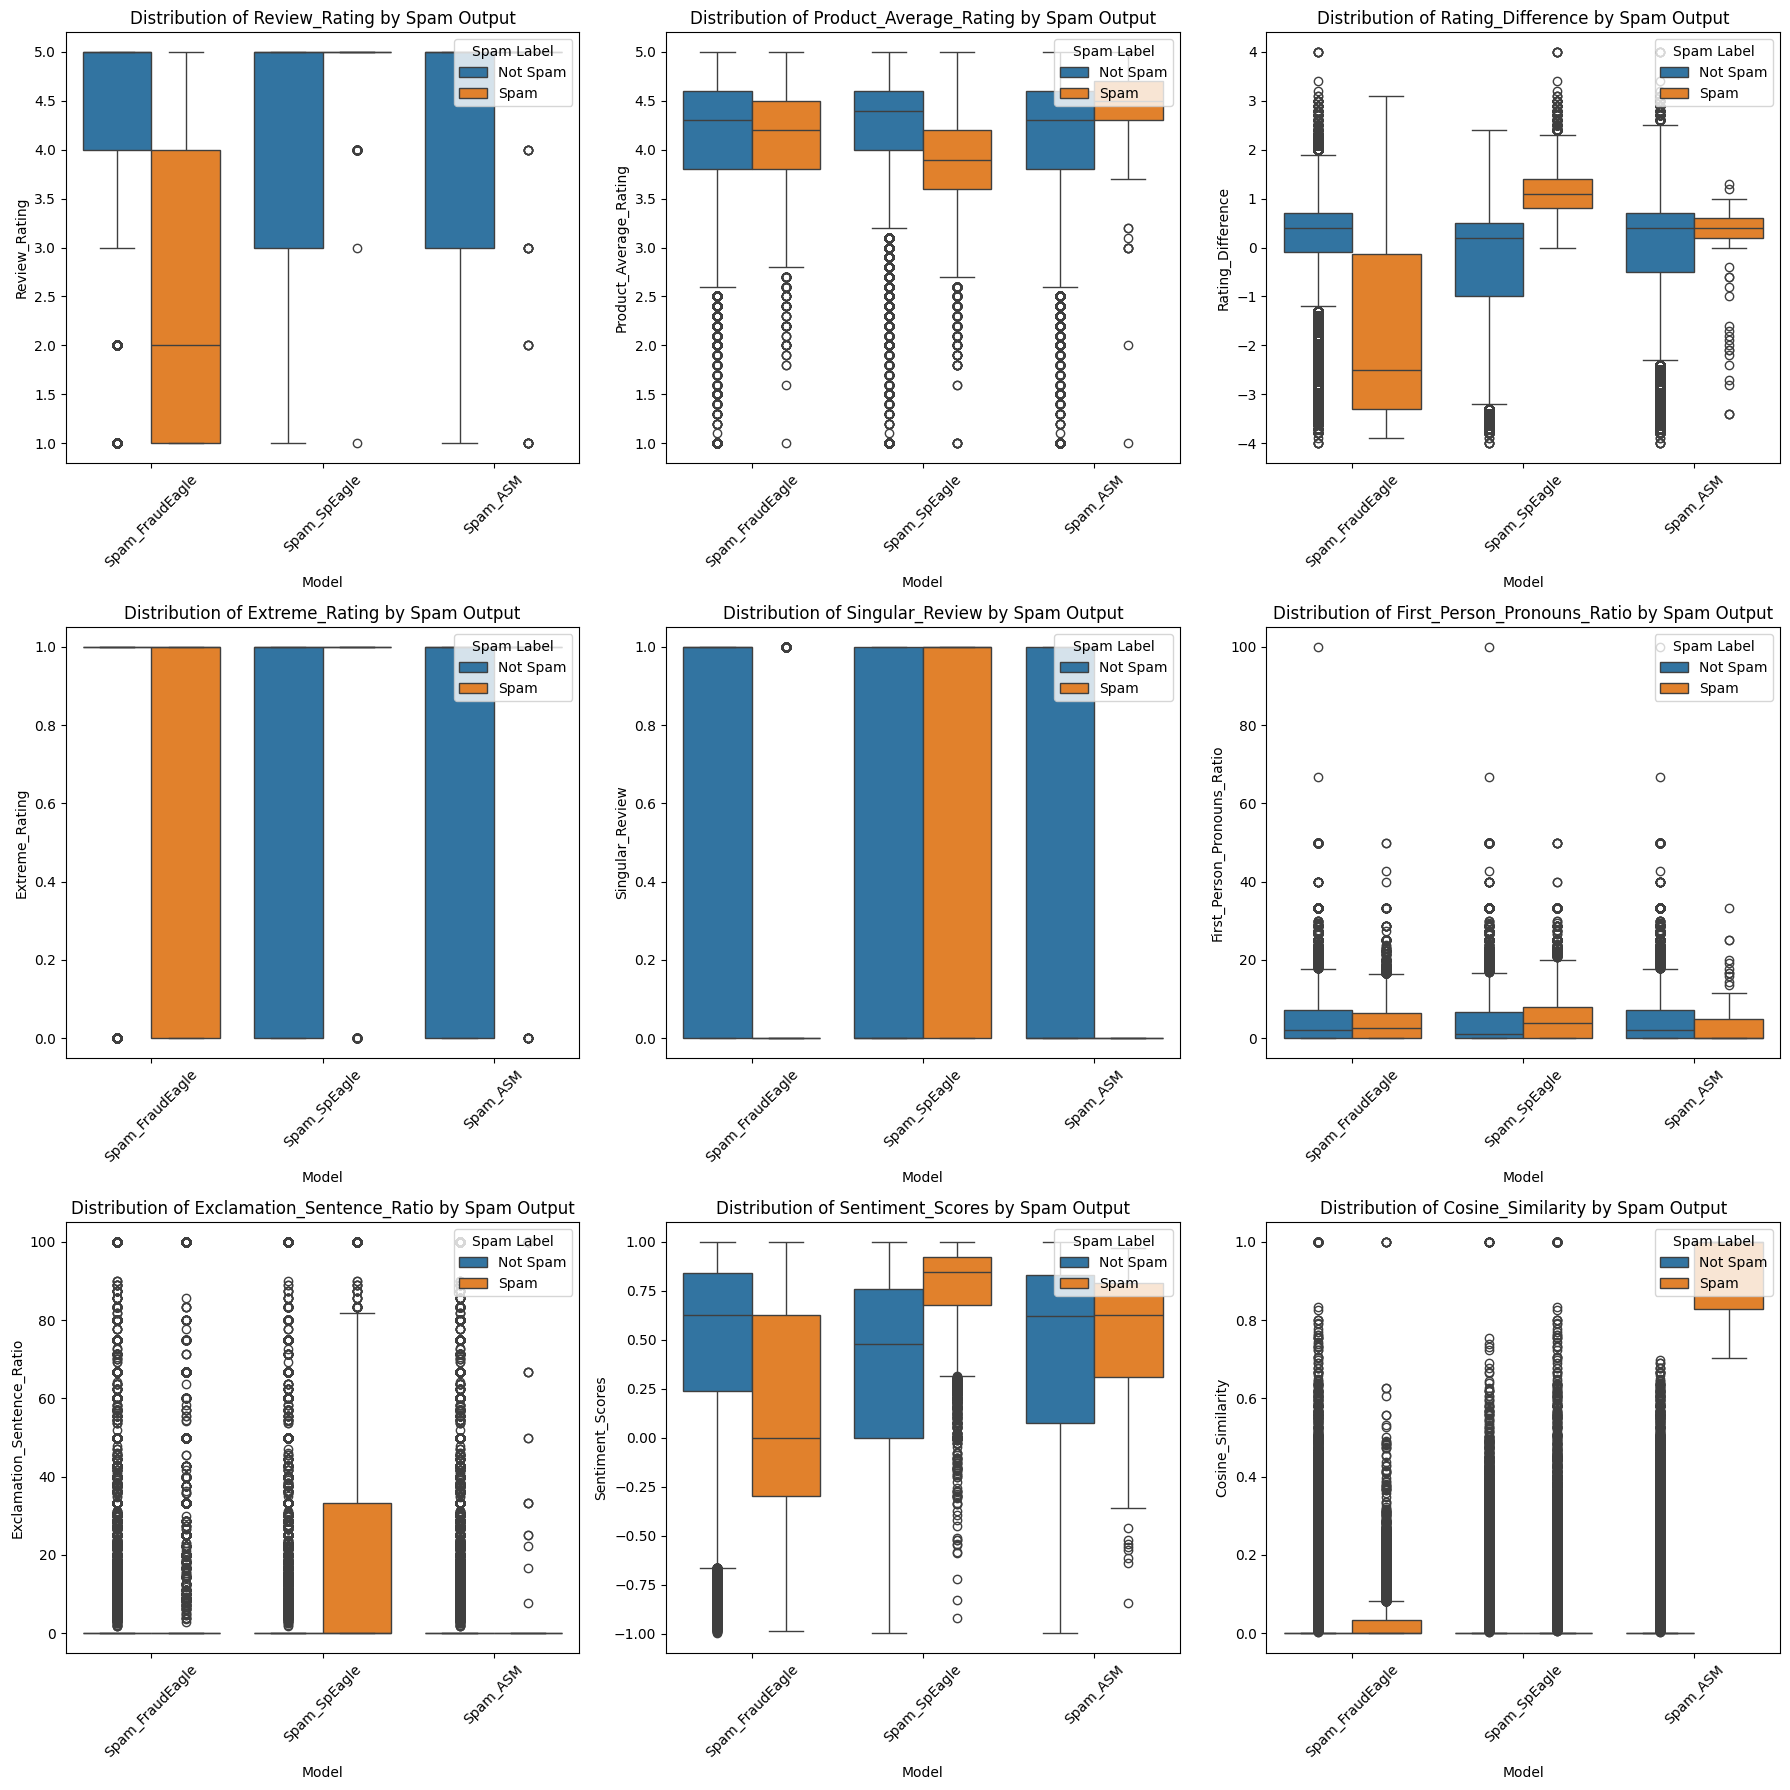

In [10]:
# Perform ANOVA test to find significant features
significant_features = []
p_value_threshold = 0.05

for feature in feature_cols:
    groups = [
        full_df[full_df['Spam_FraudEagle'] == 1][feature].dropna(),
        full_df[full_df['Spam_SpEagle'] == 1][feature].dropna(),
        full_df[full_df['Spam_ASM'] == 1][feature].dropna()
    ]
    f_stat, p_value = f_oneway(*groups)
    
    if p_value < p_value_threshold:
        significant_features.append(feature)

# Mapping for better readability
spam_label_mapping = {0: 'Not Spam', 1: 'Spam'}

# Efficient visualization with subplots for significant features
num_features = len(significant_features)
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols

plt.figure(figsize=(18, num_rows * 6))

for i, feature in enumerate(significant_features):
    plt.subplot(num_rows, num_cols, i + 1)
    
    # Combine the feature with spam outputs for visualization
    melted_df = full_df.melt(id_vars=['Review_ID', feature], value_vars=['Spam_FraudEagle', 'Spam_SpEagle', 'Spam_ASM'],
                             var_name='Model', value_name='Spam')
    
    # Map the spam labels
    melted_df['Spam'] = melted_df['Spam'].map(spam_label_mapping)
    
    sns.boxplot(data=melted_df, x='Model', y=feature, hue='Spam')
    plt.title(f'Distribution of {feature} by Spam Output')
    plt.xticks(rotation=45)
    plt.legend(loc='upper right', title='Spam Label')

plt.tight_layout()
plt.show()

### Finding the average rating spam and non-spam per model

In [11]:
# Names of the spam detection model flags in your DataFrame
spam_models = ['Spam_FraudEagle', 'Spam_SpEagle', 'Spam_ASM']

# Initialize an empty dictionary to store results
average_ratings = {}

for model in spam_models:
    # Group by the spam flag (0 for non-spam, 1 for spam) and calculate the mean of the Review Rating
    grouped = full_df.groupby(model)['Review_Rating'].mean()
    average_ratings[model] = {
        'Non-Spam Average Rating': grouped[0],
        'Spam Average Rating': grouped[1]
    }

# Convert the results dictionary to a DataFrame for better readability
average_ratings_df = pd.DataFrame(average_ratings).T  # Transpose for better formatting

# Print the results
print(average_ratings_df)

                 Non-Spam Average Rating  Spam Average Rating
Spam_FraudEagle                 4.256819             2.275631
Spam_SpEagle                    3.817438             4.998185
Spam_ASM                        4.073276             4.368932


### Pairwise agreement

#### Cohen's Kappa

In [12]:
# Calculate Cohen's Kappa for pairwise agreements
kappa_fraud_speagle = cohen_kappa_score(combined_df['Spam_FraudEagle'], combined_df['Spam_SpEagle'])
kappa_fraud_asm = cohen_kappa_score(combined_df['Spam_FraudEagle'], combined_df['Spam_ASM'])
kappa_speagle_asm = cohen_kappa_score(combined_df['Spam_SpEagle'], combined_df['Spam_ASM'])

print(f"Cohen's Kappa between FraudEagle and SpEagle: {kappa_fraud_speagle}")
print(f"Cohen's Kappa between FraudEagle and ASM: {kappa_fraud_asm}")
print(f"Cohen's Kappa between SpEagle and ASM: {kappa_speagle_asm}")


Cohen's Kappa between FraudEagle and SpEagle: -0.06614511829987335
Cohen's Kappa between FraudEagle and ASM: -0.000506192928559468
Cohen's Kappa between SpEagle and ASM: 0.0036035618231509137


#### Fleiss' Kappa

In [13]:
# Define function to calculate Fleiss' Kappa
def fleiss_kappa(ratings):
    n, k = ratings.shape
    N = n * k
    # Sum of ratings squared
    p_sum = np.sum(np.square(np.sum(ratings, axis=1)) - n)
    P = (1 / (N * (N - 1))) * p_sum
    # Sum of the squared mean ratings
    P_e = np.sum(np.square(np.mean(ratings, axis=0)))
    kappa = (P - P_e) / (1 - P_e)
    return kappa

# Create a ratings matrix for Fleiss' Kappa calculation
ratings_matrix = combined_df[['Spam_FraudEagle', 'Spam_SpEagle', 'Spam_ASM']].values

# Calculate Fleiss' Kappa
fleiss_kappa_value = fleiss_kappa(ratings_matrix)
print(f"Fleiss' Kappa: {fleiss_kappa_value}")

Fleiss' Kappa: -0.06403892925818729


#### Jaccard Similarity

In [14]:
# Calculate Jaccard similarity for pairwise agreements
jaccard_fraud_speagle = jaccard_score(combined_df['Spam_FraudEagle'], combined_df['Spam_SpEagle'])
jaccard_fraud_asm = jaccard_score(combined_df['Spam_FraudEagle'], combined_df['Spam_ASM'])
jaccard_speagle_asm = jaccard_score(combined_df['Spam_SpEagle'], combined_df['Spam_ASM'])

print(f"Jaccard similarity between FraudEagle and SpEagle: {jaccard_fraud_speagle}")
print(f"Jaccard similarity between FraudEagle and ASM: {jaccard_fraud_asm}")
print(f"Jaccard similarity between SpEagle and ASM: {jaccard_speagle_asm}")

Jaccard similarity between FraudEagle and SpEagle: 0.037428967739048725
Jaccard similarity between FraudEagle and ASM: 0.0004295840194744755
Jaccard similarity between SpEagle and ASM: 0.0024905451526611934


### Visualizing the pariwise agreements

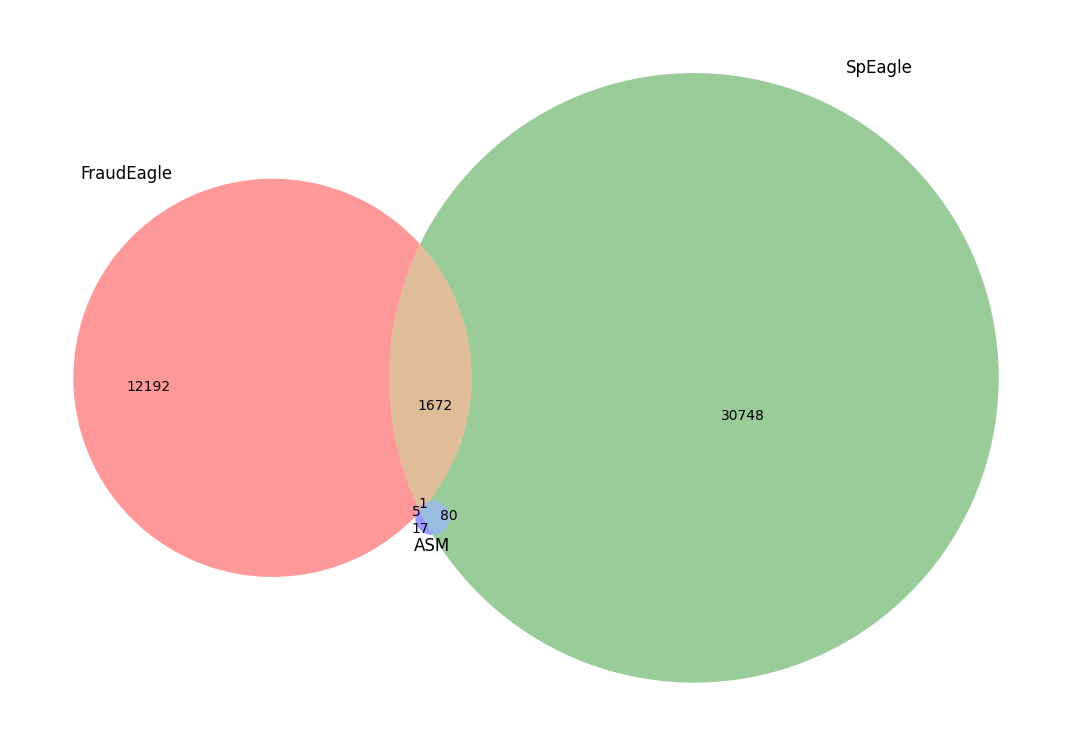

In [43]:
# Calculate set sizes for Venn diagram
fraud_eagle_set = set(combined_df[combined_df['Spam_FraudEagle'] == 1]['Review_ID'])
speagle_set = set(combined_df[combined_df['Spam_SpEagle'] == 1]['Review_ID'])
asm_set = set(combined_df[combined_df['Spam_ASM'] == 1]['Review_ID'])

plt.figure(figsize=(11.69, 8.27))  # A4 landscape mode
venn3([fraud_eagle_set, speagle_set, asm_set], ('FraudEagle', 'SpEagle', 'ASM'))
# Adjust layout to reduce whitespace
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
plt.show()

## Finding correlations with spam per model

In [16]:
# Binarize the spamicity scores based on the threshold of 0.5
fraud_eagle_df['Spam'] = (fraud_eagle_df['Spam_Probability'] > 0.5).astype(int)
speagle_df['Spam'] = (speagle_df['Review_Spam_Probability'] > 0.5).astype(int)
asm_df['Spam'] = (asm_df['Review_Spamicity'] > 0.5).astype(int)

In [17]:
# Specify the columns to keep
columns_to_keep = [
    'Review_Rating', 'Helpful_Votes', 'Verified_Purchase', 
    'Product_Average_Rating', 'Count_product_ratings', 'Review_Text_Length', 
    'Rating_Difference', 'Review_Rank', 'Extreme_Rating', 'Average_Text_Length', 
    'Text_Length_Difference', 'Review_Count', 'Singular_Review', 'Review_Word_Count',
    'Fully_Capitalized_Words_Count', 'Fully_Capitalized_Words_Proportion',
    'Capital_Letters_Excluding_Start_Count', 'Capital_Letters_Excluding_Start_Percentage',
    'First_Person_Pronouns_Count', 'First_Person_Pronouns_Ratio', 'Exclamation_Sentence_Ratio',
    'Sentiment_Scores', 'Cosine_Similarity', 'Review_ID', 'Spam', 'overall_category'
]

# Filter the dataframes to keep only the specified columns
fraud_eagle_df = fraud_eagle_df[columns_to_keep]
speagle_df = speagle_df[columns_to_keep]
asm_df = asm_df[columns_to_keep]

In [18]:
# Define feature columns for correlation analysis
feature_cols = [
    'Review_Rating', 'Helpful_Votes', 'Verified_Purchase', 
    'Product_Average_Rating', 'Count_product_ratings', 'Review_Text_Length', 
    'Rating_Difference', 'Review_Rank', 'Extreme_Rating', 'Average_Text_Length', 
    'Text_Length_Difference', 'Review_Count', 'Singular_Review', 'Review_Word_Count',
    'Fully_Capitalized_Words_Count', 'Fully_Capitalized_Words_Proportion',
    'Capital_Letters_Excluding_Start_Count', 'Capital_Letters_Excluding_Start_Percentage',
    'First_Person_Pronouns_Count', 'First_Person_Pronouns_Ratio', 'Exclamation_Sentence_Ratio',
    'Sentiment_Scores', 'Cosine_Similarity'
]

### Correlation heatmap
All rows except for spam are the same, therefore not very useful

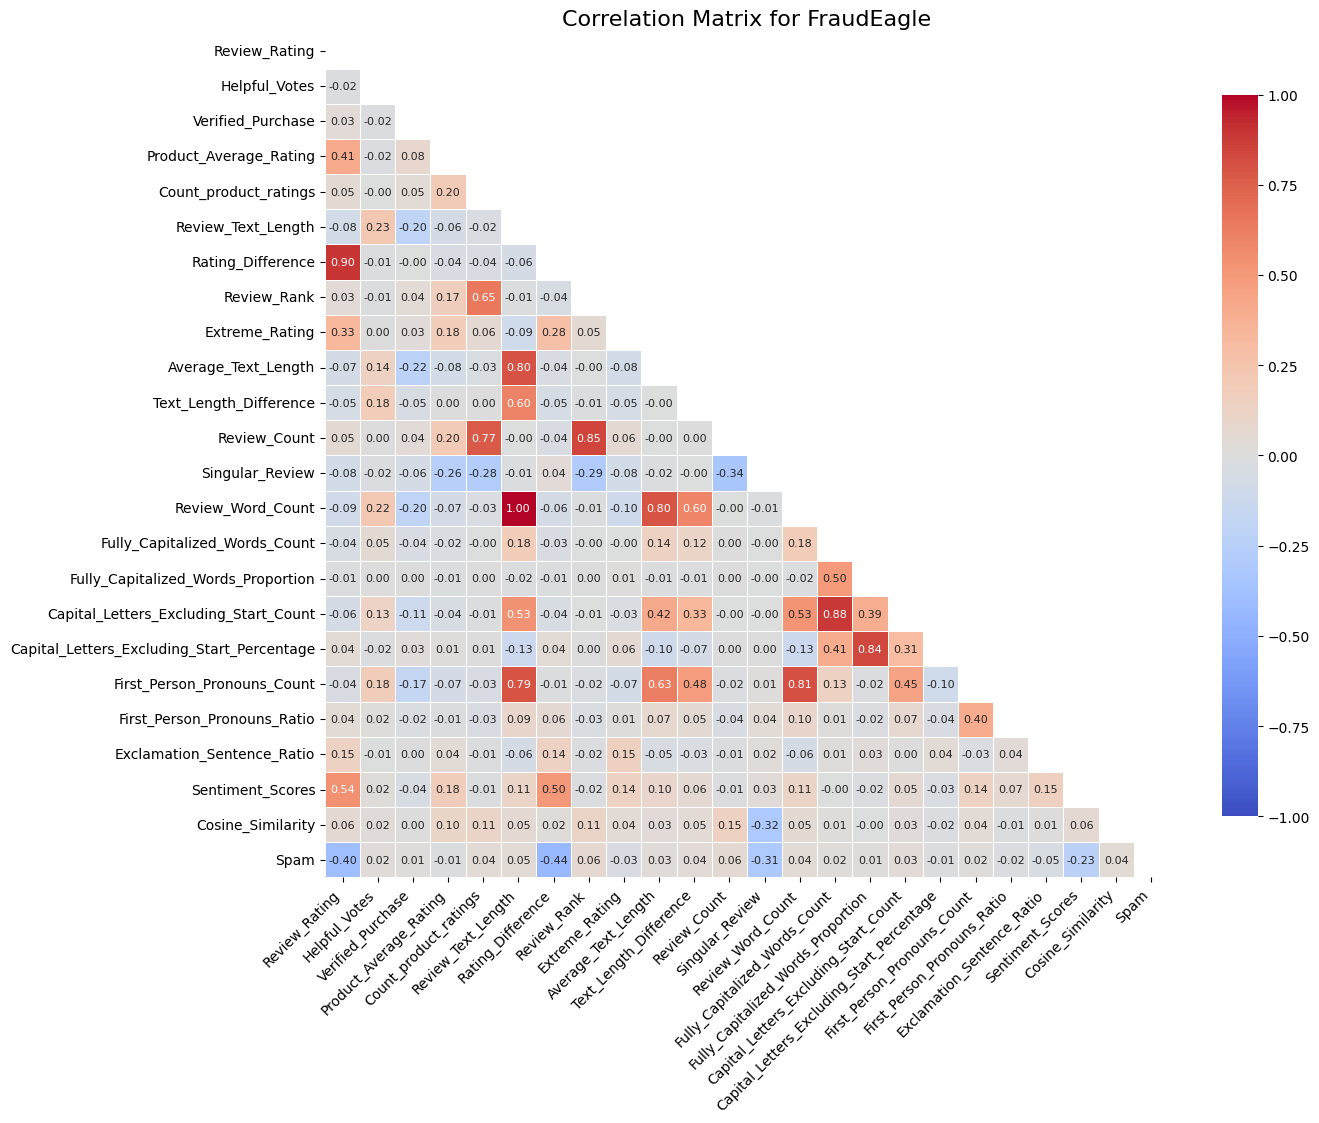

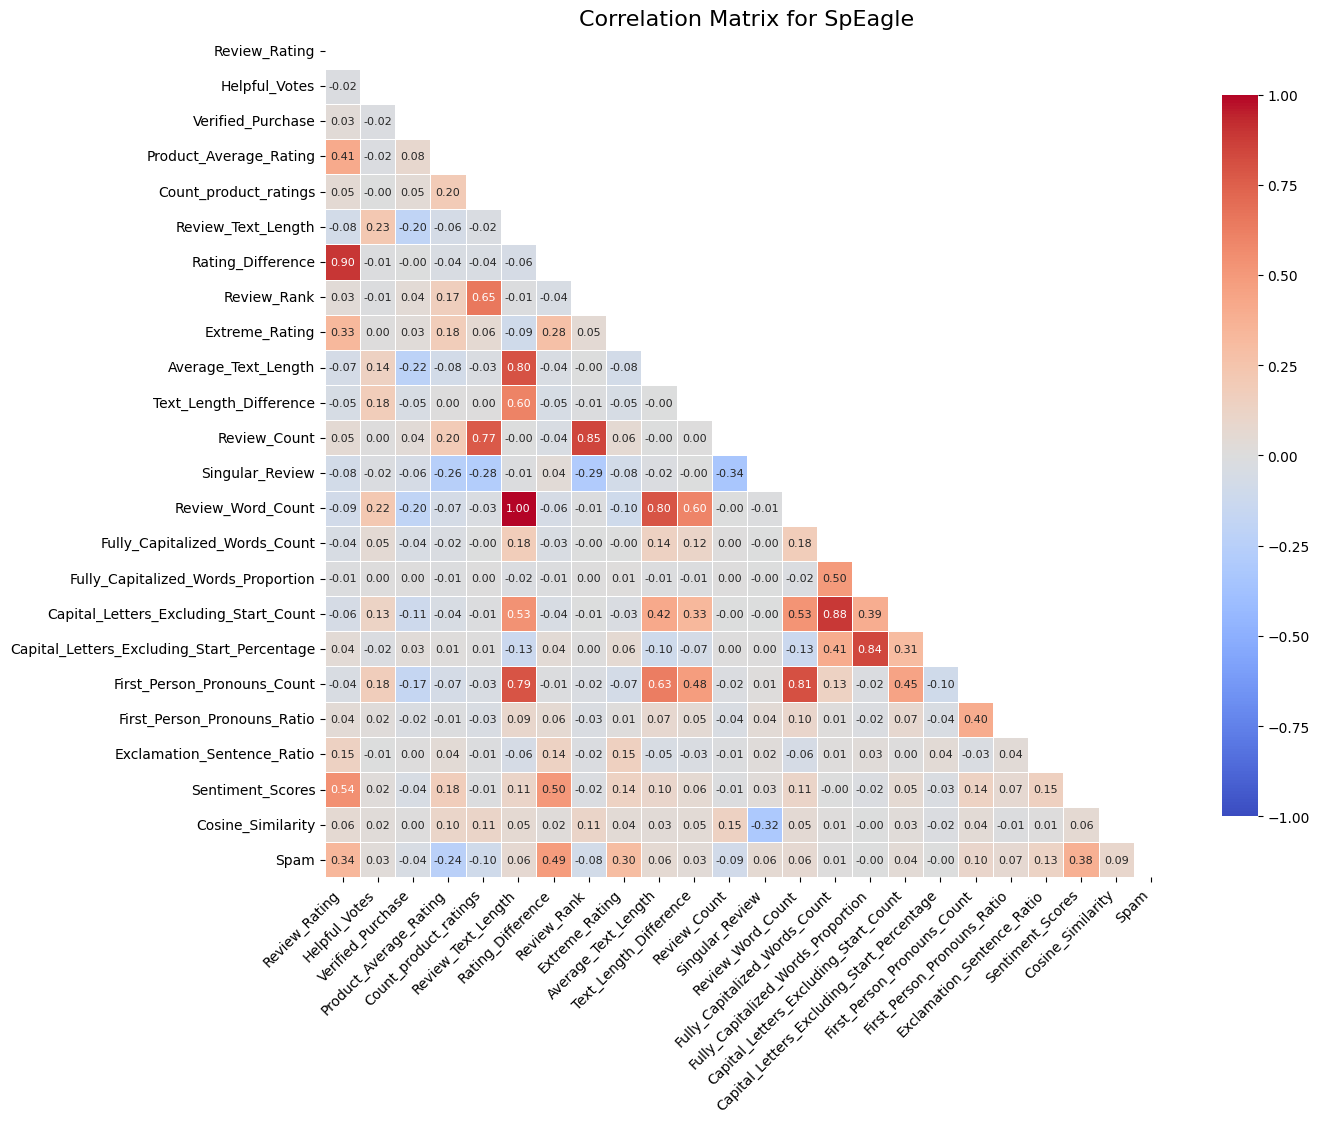

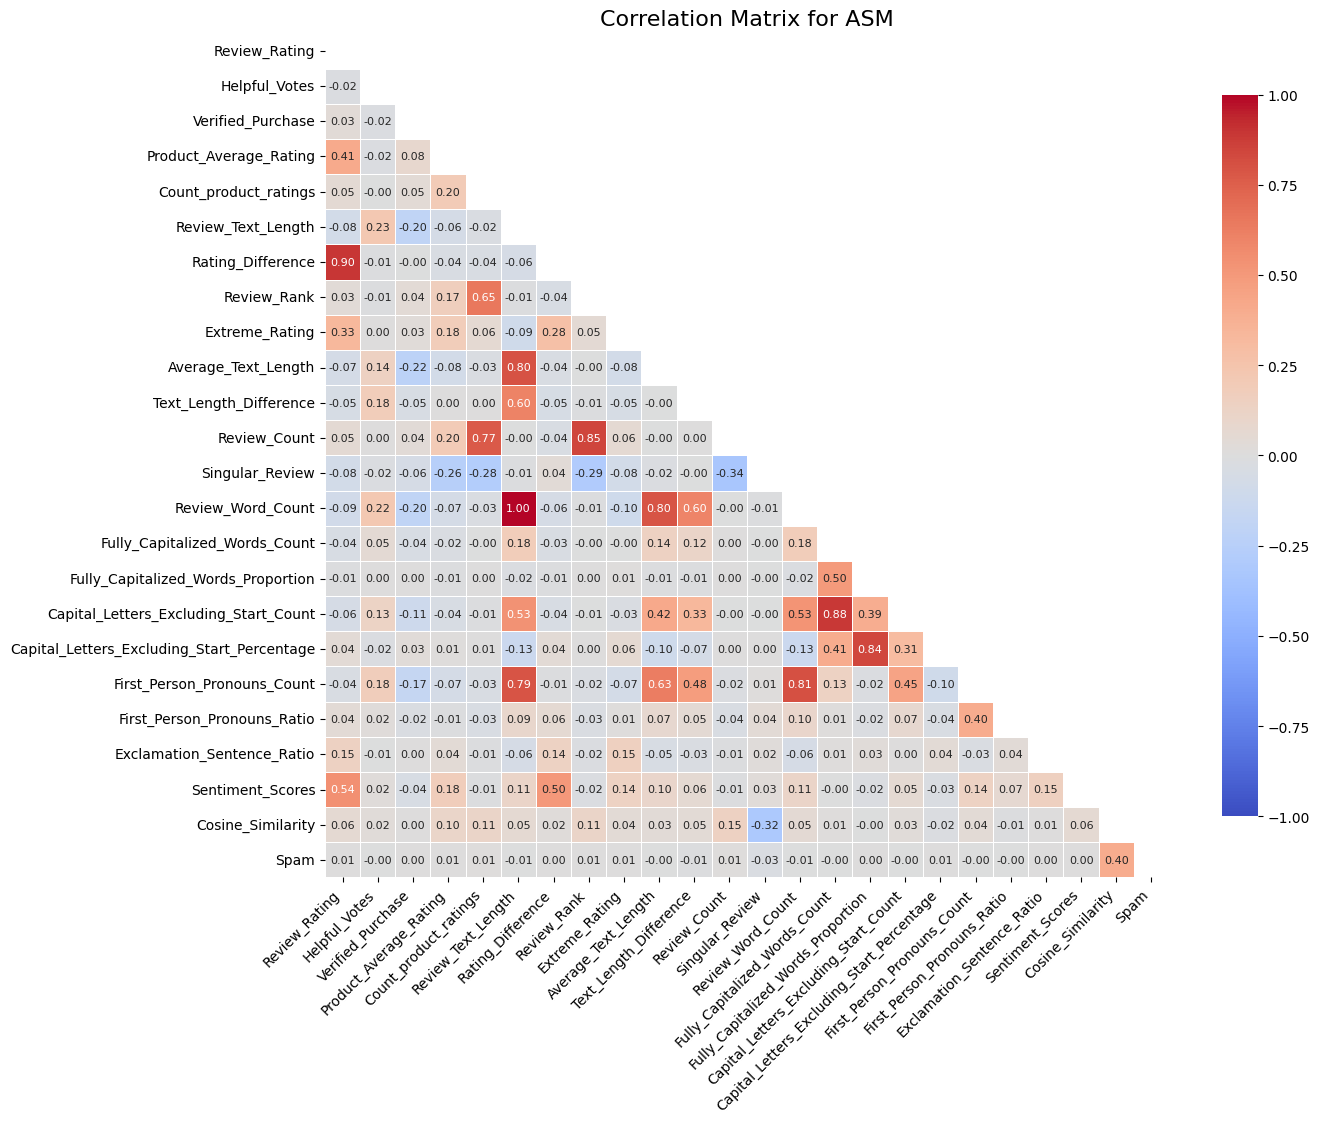

In [19]:
def heatmap_with_sizes(df, title):
    corr = df[feature_cols + ['Spam']].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    fig, ax = plt.subplots(figsize=(14, 12))
    
    sns.heatmap(corr, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, center=0, 
                annot=True, annot_kws={"size": 8}, fmt='.2f', 
                square=True, linewidths=.5, cbar_kws={"shrink": .75}, ax=ax)
    
    # Add sizes
    for i in range(len(corr.columns)):
        for j in range(i+1, len(corr.columns)):
            size = abs(corr.iloc[i, j])
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='none', lw=size * 6, alpha=0.5))
    
    ax.set_xticks(np.arange(len(corr.columns)) + 0.5)
    ax.set_yticks(np.arange(len(corr.columns)) + 0.5)
    ax.set_xticklabels(corr.columns, rotation=45, ha='right', fontsize=10)
    ax.set_yticklabels(corr.columns, rotation=0, fontsize=10)
    ax.set_title(title, size=16)
    plt.tight_layout()
    plt.show()

# Correlation analysis for FraudEagle
heatmap_with_sizes(fraud_eagle_df, 'Correlation Matrix for FraudEagle')

# Repeat for SpEagle and ASM
heatmap_with_sizes(speagle_df, 'Correlation Matrix for SpEagle')
heatmap_with_sizes(asm_df, 'Correlation Matrix for ASM')

### Extract spam's correlation row for all models and improve visualization

In [20]:
# Compute correlation matrices
corr_fraud_eagle = fraud_eagle_df[feature_cols + ['Spam']].corr()
corr_speagle = speagle_df[feature_cols + ['Spam']].corr()
corr_asm = asm_df[feature_cols + ['Spam']].corr()

# Extract correlations of 'Spam' with all features
spam_corr_fraud_eagle = corr_fraud_eagle['Spam'].drop('Spam')
spam_corr_speagle = corr_speagle['Spam'].drop('Spam')
spam_corr_asm = corr_asm['Spam'].drop('Spam')

# Combine these correlations into a single DataFrame
spam_correlations = pd.DataFrame({
    'Feature': spam_corr_fraud_eagle.index,
    'FraudEagle': spam_corr_fraud_eagle.values,
    'SpEagle': spam_corr_speagle.values,
    'ASM': spam_corr_asm.values
})

# Round the correlation values to three decimal places
spam_correlations = spam_correlations.round(3)

# Display the table
print("Correlations of Features with Spam Column Across Different Datasets:")
print(spam_correlations)

Correlations of Features with Spam Column Across Different Datasets:
                                       Feature  FraudEagle  SpEagle    ASM
0                                Review_Rating      -0.404    0.342  0.005
1                                Helpful_Votes       0.024    0.030 -0.002
2                            Verified_Purchase       0.011   -0.042  0.001
3                       Product_Average_Rating      -0.013   -0.238  0.008
4                        Count_product_ratings       0.044   -0.096  0.010
5                           Review_Text_Length       0.045    0.064 -0.006
6                            Rating_Difference      -0.437    0.492  0.002
7                                  Review_Rank       0.063   -0.083  0.007
8                               Extreme_Rating      -0.033    0.302  0.006
9                          Average_Text_Length       0.028    0.056 -0.002
10                      Text_Length_Difference       0.038    0.032 -0.008
11                             

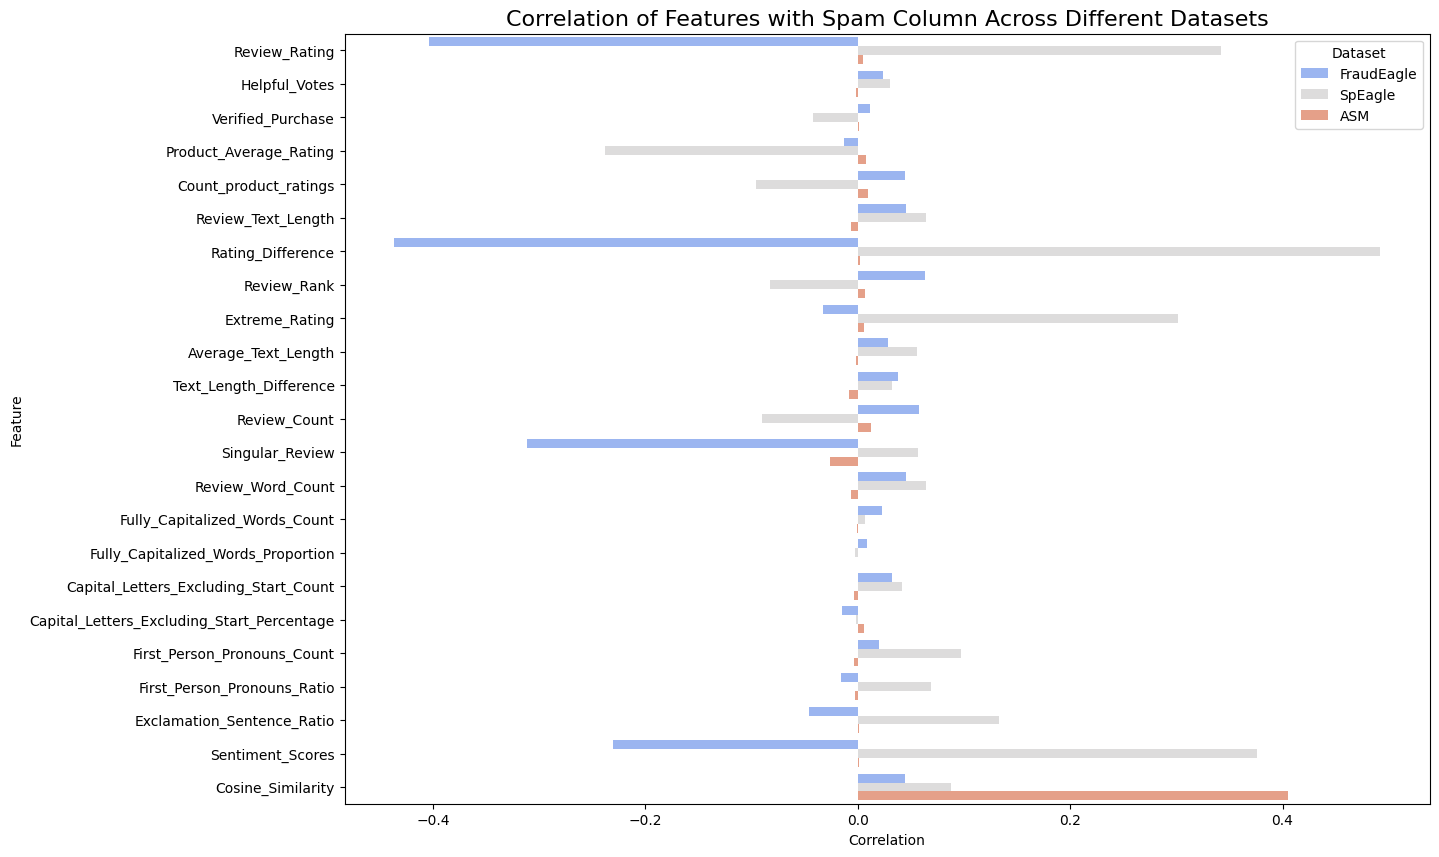

In [21]:
# Melt the DataFrame for easier plotting with seaborn
spam_correlations_melted = pd.melt(spam_correlations, id_vars='Feature', var_name='Dataset', value_name='Correlation')

# Create a bar plot
plt.figure(figsize=(14, 10))
sns.barplot(x='Correlation', y='Feature', hue='Dataset', data=spam_correlations_melted, palette='coolwarm')
plt.title('Correlation of Features with Spam Column Across Different Datasets', size=16)
plt.xlabel('Correlation')
plt.ylabel('Feature')
plt.legend(title='Dataset')
plt.show()

### Correlations with Spam

C:\Users\Maurits\AppData\Local\Temp\ipykernel_14264\943017566.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=spam_corr.values, y=spam_corr.index, palette=colors)


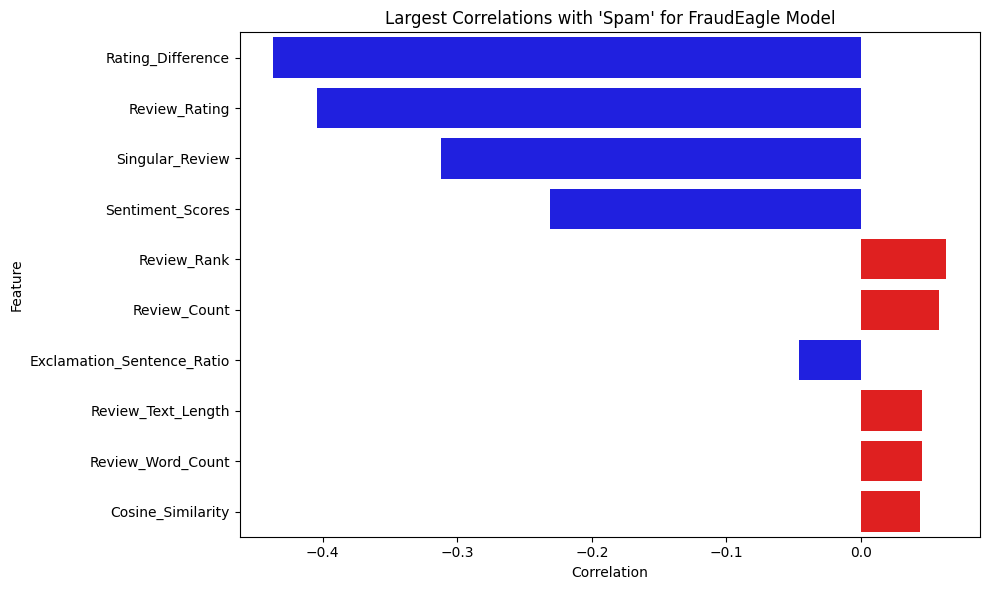

C:\Users\Maurits\AppData\Local\Temp\ipykernel_14264\943017566.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=spam_corr.values, y=spam_corr.index, palette=colors)


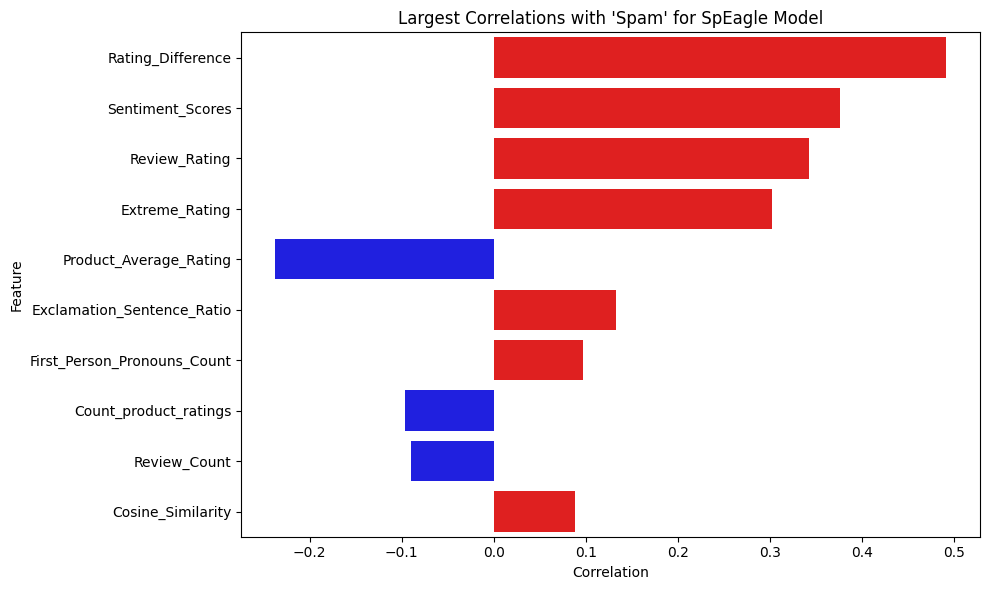

C:\Users\Maurits\AppData\Local\Temp\ipykernel_14264\943017566.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=spam_corr.values, y=spam_corr.index, palette=colors)


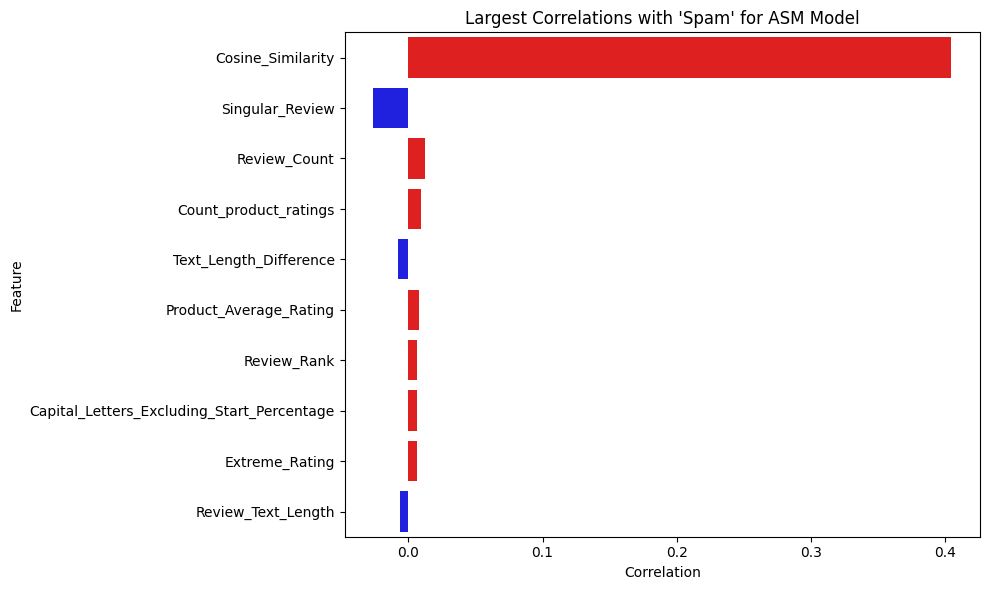

In [22]:
def plot_largest_correlations(df, model_name):
    corr = df[feature_cols + ['Spam']].corr()
    spam_corr = corr['Spam'].drop('Spam').sort_values(key=abs, ascending=False).head(10)
    colors = ['red' if c > 0 else 'blue' for c in spam_corr.values]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=spam_corr.values, y=spam_corr.index, palette=colors)
    plt.title(f"Largest Correlations with 'Spam' for {model_name} Model")
    plt.xlabel('Correlation')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

# Plot largest correlations for each model
plot_largest_correlations(fraud_eagle_df, 'FraudEagle')
plot_largest_correlations(speagle_df, 'SpEagle')
plot_largest_correlations(asm_df, 'ASM')

### Compare the correlations

<Figure size 1400x800 with 0 Axes>

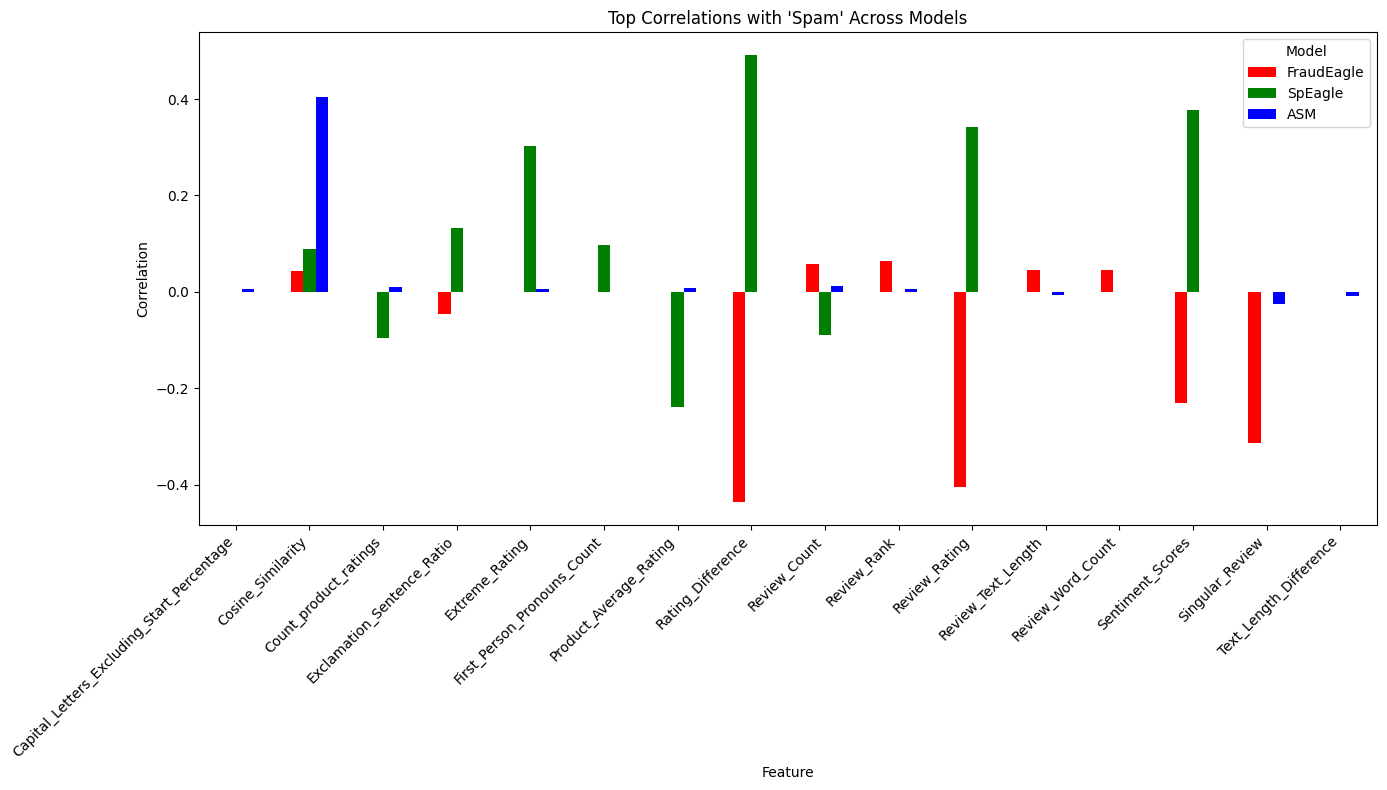

In [23]:
def get_top_correlations(df, model_name, n=10):
    corr = df[feature_cols + ['Spam']].corr()
    spam_corr = corr['Spam'].drop('Spam').sort_values(key=abs, ascending=False).head(n)
    return pd.DataFrame({'Feature': spam_corr.index, model_name: spam_corr.values})

# Get top correlations for each model
top_corr_fraud = get_top_correlations(fraud_eagle_df, 'FraudEagle')
top_corr_speagle = get_top_correlations(speagle_df, 'SpEagle')
top_corr_asm = get_top_correlations(asm_df, 'ASM')

# Merge the top correlations
top_corr_merged = top_corr_fraud.merge(top_corr_speagle, on='Feature', how='outer').merge(top_corr_asm, on='Feature', how='outer').set_index('Feature')
top_corr_merged = top_corr_merged.sort_index()

# Plot the merged correlations
plt.figure(figsize=(14, 8))
top_corr_merged.plot(kind='bar', color=['red', 'green', 'blue'], figsize=(14, 8))
plt.title("Top Correlations with 'Spam' Across Models")
plt.xlabel('Feature')
plt.ylabel('Correlation')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

## Comparing the models outputs over the various categories

In [24]:
# Calculate the overall spam proportion for each model
overall_fraud_eagle_spam = fraud_eagle_df['Spam'].mean()
overall_speagle_spam = speagle_df['Spam'].mean()
overall_asm_spam = asm_df['Spam'].mean()

In [25]:
# Calculate the proportion of spam reviews for each 'overall_category' in each DataFrame
fraud_eagle_prop = fraud_eagle_df.groupby('overall_category')['Spam'].mean().reset_index()
fraud_eagle_prop.columns = ['overall_category', 'FraudEagle_Spam_Proportion']
fraud_eagle_prop['Normalized_FraudEagle_Spam_Proportion'] = fraud_eagle_prop['FraudEagle_Spam_Proportion'] / overall_fraud_eagle_spam

speagle_prop = speagle_df.groupby('overall_category')['Spam'].mean().reset_index()
speagle_prop.columns = ['overall_category', 'Speagle_Spam_Proportion']
speagle_prop['Normalized_Speagle_Spam_Proportion'] = speagle_prop['Speagle_Spam_Proportion'] / overall_speagle_spam

asm_prop = asm_df.groupby('overall_category')['Spam'].mean().reset_index()
asm_prop.columns = ['overall_category', 'ASM_Spam_Proportion']
asm_prop['Normalized_ASM_Spam_Proportion'] = asm_prop['ASM_Spam_Proportion'] / overall_asm_spam

In [26]:
# Merge the normalized proportions into a single DataFrame
merged_normalized_props = fraud_eagle_prop[['overall_category', 'Normalized_FraudEagle_Spam_Proportion']].merge(
    speagle_prop[['overall_category', 'Normalized_Speagle_Spam_Proportion']], on='overall_category').merge(
    asm_prop[['overall_category', 'Normalized_ASM_Spam_Proportion']], on='overall_category')

# Melt the DataFrame for easier plotting with Seaborn
melted_normalized_props = merged_normalized_props.melt(id_vars='overall_category', var_name='Model', value_name='Normalized_Spam_Proportion')

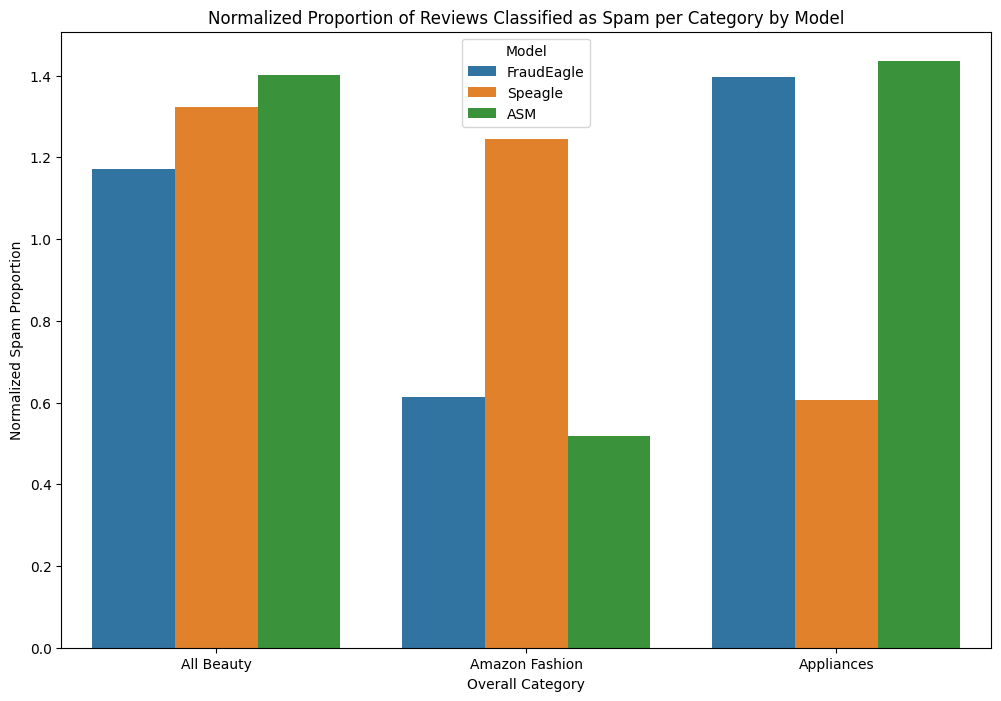

In [27]:
# Plot the normalized proportions
plt.figure(figsize=(12, 8))
plot = sns.barplot(data=melted_normalized_props, x='overall_category', y='Normalized_Spam_Proportion', hue='Model')
plt.title('Normalized Proportion of Reviews Classified as Spam per Category by Model')
plt.xlabel('Overall Category')
plt.ylabel('Normalized Spam Proportion')

# Update legend labels and colors
handles, labels = plot.get_legend_handles_labels()
plot.legend(handles, ['FraudEagle', 'Speagle', 'ASM'], title='Model')

plt.show()

## Topic Modelling

In [28]:
#Re-read dataframes
# Read the dataframes
fraud_eagle_topic_df = pd.read_csv(fraud_eagle_path)
speagle_topic_df = pd.read_csv(speagle_path)
asm_topic_df = pd.read_csv(asm_path)

C:\Users\Maurits\AppData\Local\Temp\ipykernel_14264\1338891239.py:3: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  fraud_eagle_topic_df = pd.read_csv(fraud_eagle_path)
C:\Users\Maurits\AppData\Local\Temp\ipykernel_14264\1338891239.py:4: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  speagle_topic_df = pd.read_csv(speagle_path)
C:\Users\Maurits\AppData\Local\Temp\ipykernel_14264\1338891239.py:5: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  asm_topic_df = pd.read_csv(asm_path)


In [29]:
# Select relevant columns
# FraudEagle
metrics_LDA_fraud_eagle = fraud_eagle_topic_df[['Review_Text', 'Review_ID', 'Spam_Probability']]

# SpEagle
metrics_LDA_speagle = speagle_topic_df[['Review_Text', 'Review_ID', 'Review_Spam_Probability']]

# ASM
metrics_LDA_asm = asm_topic_df[['Review_Text', 'Review_ID', 'Review_Spamicity']]

# Binarize the spamicity scores based on the threshold of 0.5
metrics_LDA_fraud_eagle['Spam'] = (metrics_LDA_fraud_eagle['Spam_Probability'] > 0.5).astype(int)
metrics_LDA_speagle['Spam'] = (metrics_LDA_speagle['Review_Spam_Probability'] > 0.5).astype(int)
metrics_LDA_asm['Spam'] = (metrics_LDA_asm['Review_Spamicity'] > 0.5).astype(int)

# Combine the binarized columns and include the review text
lda_df = metrics_LDA_fraud_eagle[['Review_ID', 'Review_Text', 'Spam']].rename(columns={'Spam': 'Spam_FraudEagle'})
lda_df = pd.merge(lda_df, metrics_LDA_speagle[['Review_ID', 'Spam']], on='Review_ID', how='left').rename(columns={'Spam': 'Spam_SpEagle'})
lda_df = pd.merge(lda_df, metrics_LDA_asm[['Review_ID', 'Spam']], on='Review_ID', how='left').rename(columns={'Spam': 'Spam_ASM'})

# Ensure review text is included in the final dataframe
lda_df = pd.merge(lda_df, metrics_LDA_fraud_eagle[['Review_ID', 'Review_Text']], on='Review_ID', how='left')

C:\Users\Maurits\AppData\Local\Temp\ipykernel_14264\748345345.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_LDA_fraud_eagle['Spam'] = (metrics_LDA_fraud_eagle['Spam_Probability'] > 0.5).astype(int)
C:\Users\Maurits\AppData\Local\Temp\ipykernel_14264\748345345.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_LDA_speagle['Spam'] = (metrics_LDA_speagle['Review_Spam_Probability'] > 0.5).astype(int)
C:\Users\Maurits\AppData\Local\Temp\ipykernel_14264\748345345.py:14: SettingWithCopyWar

In [30]:
#Splitting the dataframe per model
# For FraudEagle
lda_df_fraud_eagle = lda_df[lda_df['Spam_FraudEagle'] == 1]

# For SpEagle
lda_df_speagle = lda_df[lda_df['Spam_SpEagle'] == 1]

# For ASM
lda_df_asm = lda_df[lda_df['Spam_ASM'] == 1]

In [31]:
print(lda_df_asm.head(20))

       Review_ID                                      Review_Text_x  \
56            57                                         works well   
280          281                                              great   
1999        2000                                          excellent   
2528        2529                                        Works great   
4874        4875                    Fit perfect inexpensive perfect   
5049        5050                        Fast shipping great product   
5138        5139  Package includes two types of models. One mode...   
7510        7511             Just what I needed, like the original.   
8411        8412                                        Perfect fit   
8547        8548  I have to admit, I love the name of this produ...   
8953        8954                        fit perfectly on the fridge   
9187        9188  Installing the water filter housing was relati...   
9865        9866                              Beautiful hoops !!!!!   
10241 

In [32]:
# Function to preprocess the text
def preprocess(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

# Function to perform LDA topic modeling
def perform_lda(df, num_topics=5):
    # Drop NaN values from the review text
    df = df.dropna(subset=['Review_Text_x'])
    
    # Preprocess the review text
    processed_docs = df['Review_Text_x'].map(preprocess)
    
    # Create a dictionary and corpus for LDA
    dictionary = corpora.Dictionary(processed_docs)
    corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
    
    # Perform LDA
    lda_model = gensim.models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)
    
    return lda_model, corpus, dictionary, processed_docs

# Function to display the topics using word clouds
def display_topics_with_wordclouds(lda_model, num_words=10):
    topics = lda_model.show_topics(num_words=num_words, formatted=False)
    for topic_num, words in topics:
        word_freq = {word: freq for word, freq in words}
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Topic {topic_num+1}')
        plt.show()

In [33]:
#Printing lengths to ensure the correct df's are used in LDA
print(len(lda_df_asm))
print(len(lda_df_fraud_eagle))
print(len(lda_df_speagle))

103
13870
32501


In [34]:
# Perform LDA on each DataFrame
lda_model_fraud_eagle, corpus_fraud_eagle, dictionary_fraud_eagle, processed_docs_fraud_eagle = perform_lda(lda_df_fraud_eagle)
lda_model_speagle, corpus_speagle, dictionary_speagle, processed_docs_speagle = perform_lda(lda_df_speagle)
lda_model_asm, corpus_asm, dictionary_asm, processed_docs_asm = perform_lda(lda_df_asm)

In [35]:
# Function to extract the top words for each topic
def extract_topics(lda_model, num_words=10):
    topics = lda_model.show_topics(num_words=num_words, formatted=False)
    topic_words = {f'Topic {i+1}': [word for word, _ in words] for i, (topic_num, words) in enumerate(topics)}
    return topic_words

# Extract top words for each topic from each model
topics_fraud_eagle = extract_topics(lda_model_fraud_eagle)
topics_speagle = extract_topics(lda_model_speagle)
topics_asm = extract_topics(lda_model_asm)

# Create a DataFrame to compare the topics
topics_df = pd.DataFrame({
    'FraudEagle': pd.Series(topics_fraud_eagle),
    'SpEagle': pd.Series(topics_speagle),
    'ASM': pd.Series(topics_asm)
})

# Display the DataFrame
topics_df

,FraudEagle,SpEagle,ASM
Topic 1,"[water, ice, filter, one, months, worked, woul...","[loved, bought, loves, gift, watch, daughter, ...","[great, works, love, product, well, easy, pric..."
Topic 2,"[washer, dress, size, machine, washing, hose, ...","[ice, water, machine, use, one, little, maker,...","[good, used, one, needed, quality, like, guess..."
Topic 3,"[use, hair, would, get, put, dry, dryer, clean...","[use, product, great, love, coffee, easy, hair...","[easy, use, refrigerator, filter, perfectly, c..."
Topic 4,"[like, great, fit, good, love, small, size, re...","[great, easy, fit, works, good, product, perfe...","[fit, perfect, love, like, size, excellent, on..."
Topic 5,"[coffee, one, work, product, use, get, fit, mo...","[love, great, fit, perfect, comfortable, size,...","[hair, dress, braids, braiding, woman, used, o..."


In [36]:
# Output the DataFrame to a CSV file
csv_file_path = 'topics_comparison.csv'
topics_df.to_csv(csv_file_path, index=False)